In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [7]:
from processing_functions import create_df
start_date = "2023-03-24 12:00"
end_date = "2025-02-10 10:00"
df_main = create_df(timeFramesUsedInMinutes=["5","15", "60"], instrument="ES", 
                    start_date = start_date, end_date = end_date, putVolumeInData=False) 

In [ ]:
df_main.kiju

,datetime,close,high,low,open,tenkan,kijun,ssa,ssb,ssa_15,...,ssa_60,ssb_60,kijun_60,PP,R1,R2,R3,S1,S2,S3
0,2023-03-29 20:00:00,4057.25,4059.00,4056.25,4058.50,4057.000,4049.250,4044.625,4040.750,4037.8750,...,3999.7500,3985.625,4021.125,4041.833333,4073.166667,4092.583333,4123.916667,4022.416667,3991.083333,3971.666667
1,2023-03-29 20:05:00,4058.25,4058.75,4057.00,4057.25,4057.000,4049.250,4044.125,4040.750,4037.8750,...,3999.7500,3985.625,4021.125,4041.833333,4073.166667,4092.583333,4123.916667,4022.416667,3991.083333,3971.666667
2,2023-03-29 20:10:00,4058.25,4058.75,4058.00,4058.00,4057.000,4050.000,4043.375,4040.750,4037.8750,...,3999.7500,3985.625,4021.125,4041.833333,4073.166667,4092.583333,4123.916667,4022.416667,3991.083333,3971.666667
3,2023-03-29 20:15:00,4058.50,4059.00,4058.25,4058.25,4057.000,4050.125,4043.375,4040.750,4038.5625,...,3999.7500,3985.625,4021.125,4041.833333,4073.166667,4092.583333,4123.916667,4022.416667,3991.083333,3971.666667
4,2023-03-29 20:20:00,4059.00,4059.25,4058.25,4058.50,4057.000,4050.125,4043.250,4040.750,4038.5625,...,3999.7500,3985.625,4021.125,4041.833333,4073.166667,4092.583333,4123.916667,4022.416667,3991.083333,3971.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132145,2025-02-10 09:40:00,6070.50,6071.75,6069.75,6071.75,6069.000,6067.500,6065.750,6066.750,6053.6875,...,6090.5000,6064.375,6068.625,6067.916667,6078.583333,6084.166667,6094.833333,6062.333333,6051.666667,6046.083333
132146,2025-02-10 09:45:00,6069.50,6070.50,6067.50,6070.50,6069.875,6067.500,6065.750,6066.875,6053.4375,...,6090.5000,6064.375,6068.625,6067.916667,6078.583333,6084.166667,6094.833333,6062.333333,6051.666667,6046.083333
132147,2025-02-10 09:50:00,6070.00,6070.75,6068.75,6069.50,6070.000,6067.500,6065.750,6067.000,6053.4375,...,6090.5000,6064.375,6068.625,6067.916667,6078.583333,6084.166667,6094.833333,6062.333333,6051.666667,6046.083333
132148,2025-02-10 09:55:00,6071.00,6071.25,6069.50,6070.00,6070.000,6067.500,6065.250,6067.000,6053.4375,...,6090.5000,6064.375,6068.625,6067.916667,6078.583333,6084.166667,6094.833333,6062.333333,6051.666667,6046.083333


In [6]:
df_main.isnull().sum()

datetime    0
close       0
high        0
low         0
open        0
tenkan      0
kijun       0
ssa         0
ssb         0
ssa_15      0
ssb_15      0
kijun_15    0
PP          0
R1          0
R2          0
R3          0
S1          0
S2          0
S3          0
dtype: int64

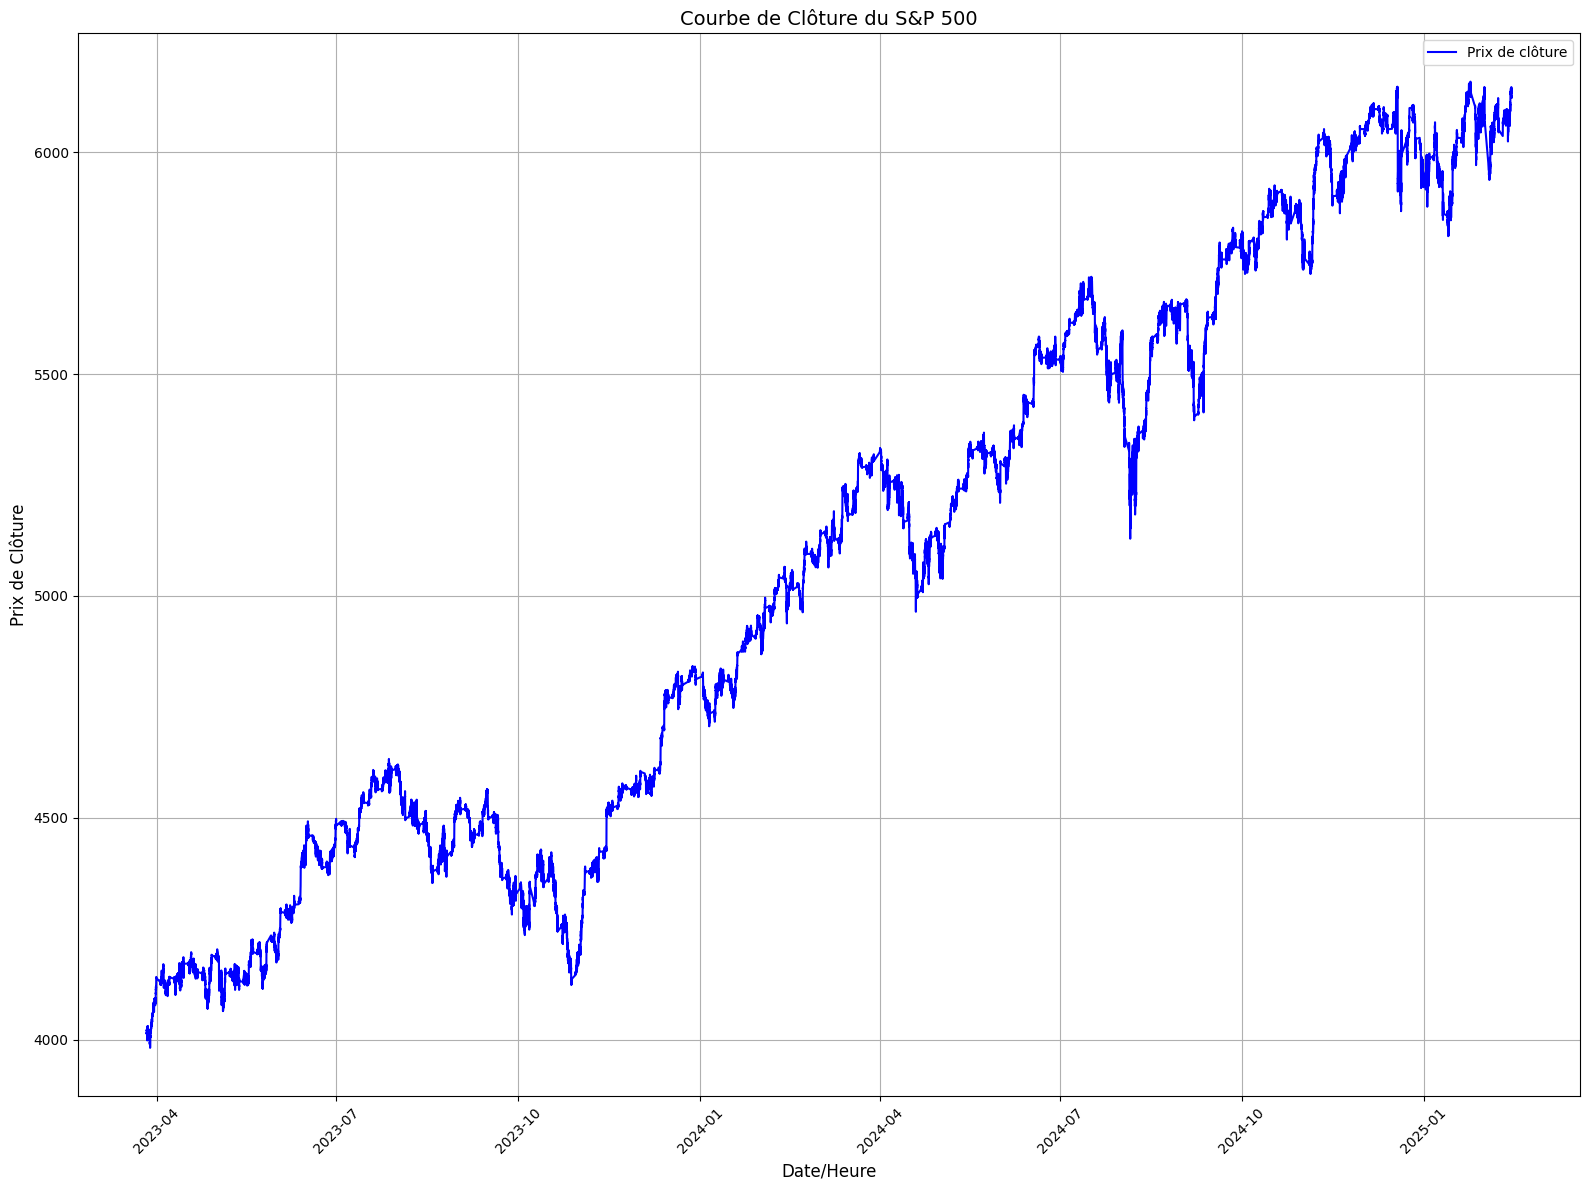

In [ ]:

import matplotlib.pyplot as plt 
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

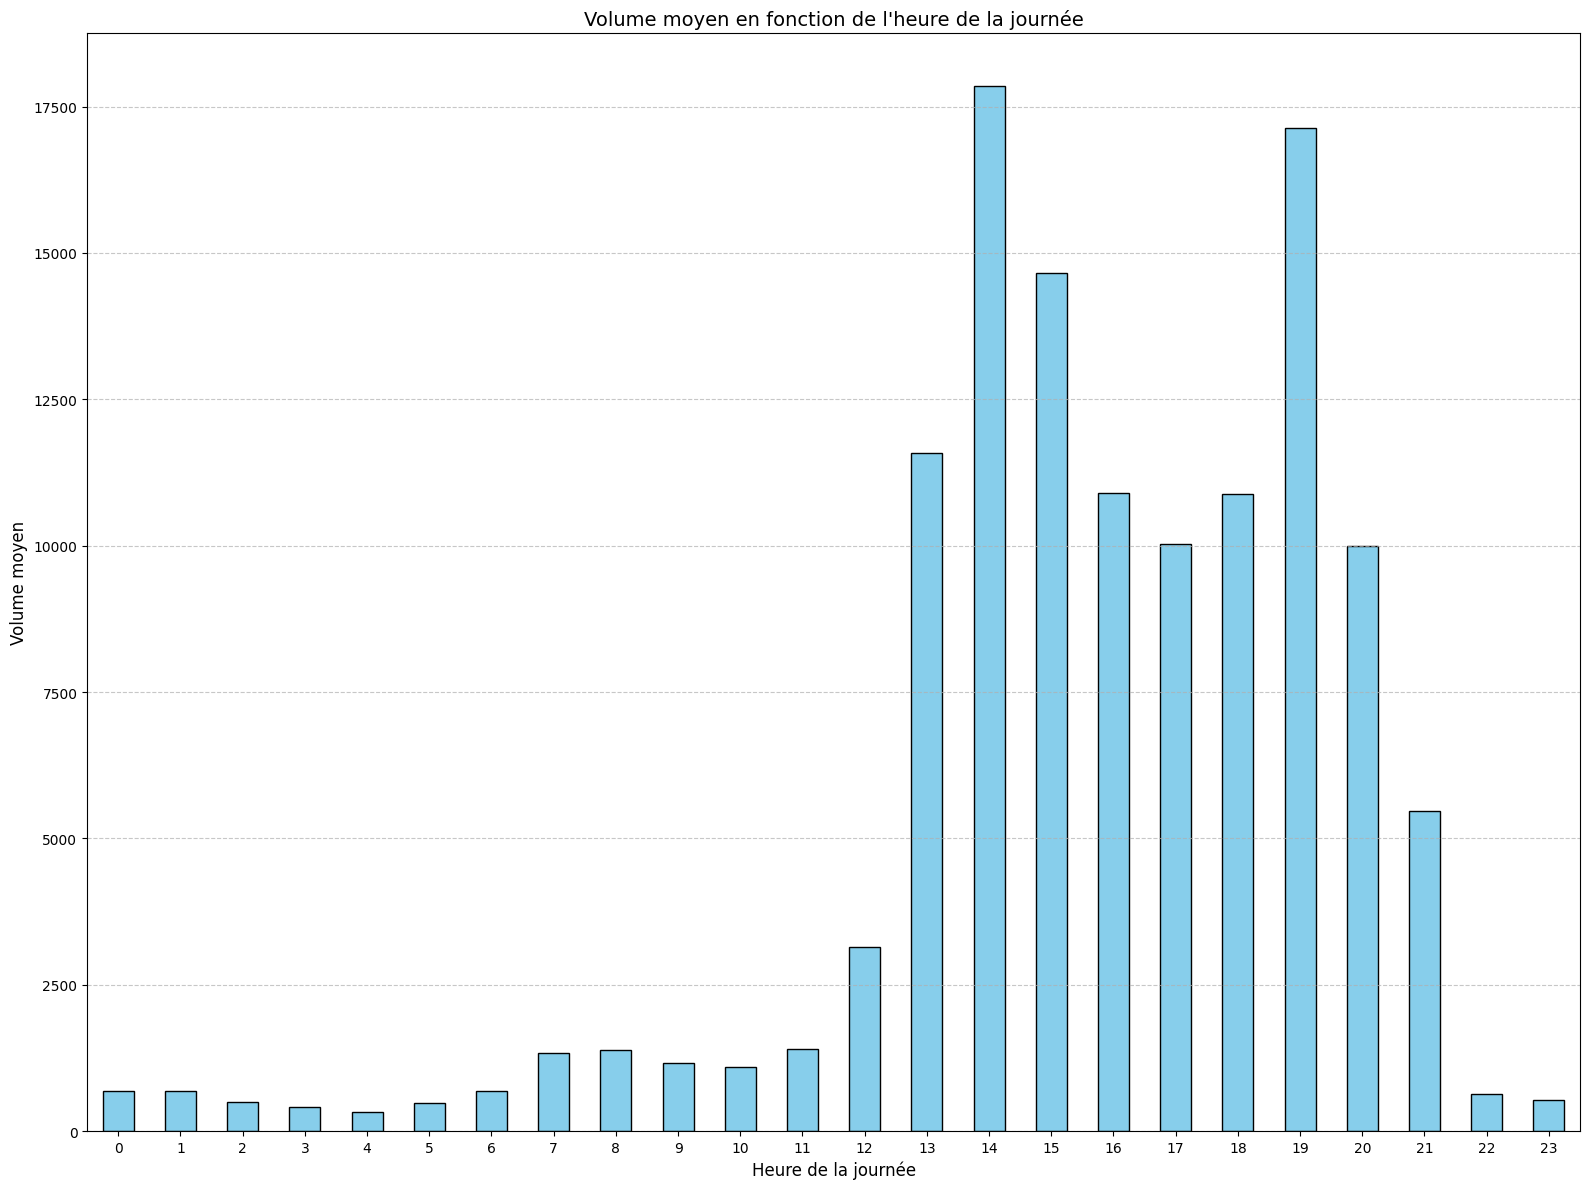

In [3]:
import matplotlib.pyplot as plt 

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

### TRY WITH US CALENDAR EVENTS ###

In [12]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak"
155,76.244,68.92,66.64,0.510,-1.282,0.40,"(613, 191, 1)",20.5,51.4,"(55, 25, 55, 60)",0 days 00:40:00,0 days 02:10:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(11, 2.77)"
123,75.577,70.92,68.58,0.503,-1.211,0.42,"(622, 201, 1)",20.2,48.5,"(50, 25, 60, 55)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(15, 2.72)"
125,75.589,71.32,69.03,0.506,-1.210,0.42,"(610, 197, 1)",20.4,48.5,"(50, 25, 60, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(14, 2.76)"
117,75.303,71.93,69.58,0.505,-1.191,0.42,"(622, 204, 1)",20.3,47.8,"(50, 25, 55, 55)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(10, 2.67)"
119,75.309,72.50,70.20,0.508,-1.192,0.43,"(610, 200, 1)",20.4,47.8,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(10, 2.71)"


In [14]:
from processing_functions import return_trade_datas_dataframe
filename = 'result_file515602'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"
tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # only > or < SSB in high TF

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak"
1,61.920,68.85,67.01,0.855,-1.113,0.77,"(400, 246, 1)",34.3,44.6,"(50, 25, 55, 60)",0 days 01:10:00,0 days 03:02:30,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,0,"(7, 1.91)"
28,76.429,69.68,67.68,0.518,-1.263,0.41,"(535, 165, 1)",20.9,50.7,"(55, 25, 55, 60)",0 days 00:40:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(19, 2.72)"
13,62.166,70.49,68.68,0.855,-1.115,0.77,"(396, 241, 1)",34.3,44.7,"(50, 25, 55, 65)",0 days 01:12:30,0 days 03:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,0,"(7, 1.92)"
16,75.793,72.42,70.45,0.515,-1.185,0.44,"(526, 168, 1)",20.7,47.6,"(50, 25, 55, 65)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.64)"
4,75.641,73.70,71.70,0.517,-1.178,0.44,"(531, 171, 1)",20.8,47.3,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.66)"


In [1]:
from processing_functions import return_trade_datas_dataframe
filename = 'result_file515602'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"
tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(5) # only > or < SSB in high TF with calendar_events

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak",calendar_event
28,75.793,70.38,68.40,0.512,-1.195,0.43,"(526, 168, 0)",20.6,47.7,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.61)","[CPI, PPI, Fed, FOMC, PCE]"
7,62.166,70.49,68.68,0.855,-1.115,0.77,"(396, 241, 1)",34.3,44.7,"(50, 25, 55, 65)",0 days 01:12:30,0 days 03:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,0,"(7, 1.92)",[]
52,75.827,71.00,69.03,0.512,-1.195,0.43,"(527, 168, 0)",20.6,47.7,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.61)","[Fed, FOMC, PCE]"
10,75.793,72.42,70.45,0.515,-1.185,0.44,"(526, 168, 1)",20.7,47.6,"(50, 25, 55, 65)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.64)",[]
4,75.641,73.70,71.70,0.517,-1.178,0.44,"(531, 171, 1)",20.8,47.3,"(50, 25, 55, 60)",0 days 00:35:00,0 days 02:05:00,"[5, 15, 60]","[[0.6, -0.5]]",0.4,14,2,1,"(13, 2.66)",[]


In [10]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(filepath, selected_Id=780)


      profit_including_fees_from_start(%)
                                      sum
count                          681.000000
mean                             0.060308
std                              1.010307
min                             -4.814200
25%                              0.000000
50%                              0.000000
75%                              0.622160
max                              4.299440 
       profit_including_fees_from_start(%)
                                      sum
count                           98.000000
mean                             0.419077
std                              2.698706
min                             -7.509080
25%                             -1.072860
50%                              0.566200
75%                              2.527710
max                              6.896600


In [2]:
from processing_functions import return_trade_datas_dataframe

filename = 'result_file1m_last2'
filepath = f"ES/2023-03-24_12-00_2025-02-10_10-00/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,bracketsModifier,percentHitToMoveTP,tpToMoveInTicks,nbrTimeMaxMoveTP,stopMethodsForKijunExitExit,"maxLossStreak, avgLossStreak",calendar_event
10,92.562,47.99,19.31,0.109,-1.327,0.08,"(9346, 751, 1)",4.5,53.1,"(55, 25, 55, 65)",0 days 00:03:50,0 days 00:13:10,"[1, 5, 15]","[[0.65, -0.4]]",0.35,11,2,1,"(84, 9.4)",[]
2,92.562,51.50,22.82,0.109,-1.325,0.08,"(9346, 751, 1)",4.5,53.0,"(55, 25, 55, 65)",0 days 00:03:50,0 days 00:13:10,"[1, 5, 15]","[[0.65, -0.4]]",0.35,10,2,1,"(84, 9.4)",[]
14,92.608,52.61,24.49,0.109,-1.330,0.08,"(9171, 732, 1)",4.5,53.2,"(55, 25, 55, 70)",0 days 00:03:50,0 days 00:13:10,"[1, 5, 15]","[[0.65, -0.4]]",0.35,11,2,1,"(97, 9.36)",[]
6,92.608,55.30,27.17,0.109,-1.329,0.08,"(9171, 732, 1)",4.5,53.1,"(55, 25, 55, 70)",0 days 00:03:50,0 days 00:13:10,"[1, 5, 15]","[[0.65, -0.4]]",0.35,10,2,1,"(97, 9.36)",[]
12,92.544,62.44,33.76,0.110,-1.324,0.09,"(9346, 753, 1)",4.5,52.9,"(55, 25, 55, 65)",0 days 00:03:50,0 days 00:13:02.500000,"[1, 5, 15]","[[0.6, -0.4], [0.85, 1.0]]",0.35,11,2,1,"(84, 9.39)",[]
16,92.590,66.81,38.68,0.111,-1.327,0.09,"(9171, 734, 1)",4.5,53.0,"(55, 25, 55, 70)",0 days 00:03:50,0 days 00:13:00,"[1, 5, 15]","[[0.6, -0.4], [0.85, 1.0]]",0.35,11,2,1,"(97, 9.35)",[]
4,92.554,68.17,39.49,0.111,-1.325,0.09,"(9347, 752, 1)",4.6,53.0,"(55, 25, 55, 65)",0 days 00:03:50,0 days 00:13:00,"[1, 5, 15]","[[0.6, -0.4], [0.85, 1.0]]",0.35,10,2,1,"(84, 9.38)",[]
8,92.590,70.17,42.04,0.111,-1.327,0.09,"(9171, 734, 1)",4.6,53.0,"(55, 25, 55, 70)",0 days 00:03:50,0 days 00:13:00,"[1, 5, 15]","[[0.6, -0.4], [0.85, 1.0]]",0.35,10,2,1,"(97, 9.35)",[]
13,52.440,114.25,107.33,1.089,-1.108,0.99,"(1279, 1160, 1)",43.7,44.2,"(55, 25, 55, 70)",0 days 01:12:00,0 days 03:21:55,"[1, 5, 15]","[[0.65, -0.4]]",0.35,11,2,0,"(11, 1.97)",[]
5,52.976,116.72,109.57,1.059,-1.100,0.97,"(1335, 1185, 0)",42.5,43.9,"(55, 25, 55, 70)",0 days 01:08:55,0 days 03:13:55,"[1, 5, 15]","[[0.65, -0.4]]",0.35,10,2,0,"(11, 1.94)",[]


In [5]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(filepath, selected_Id=11)

      profit_including_fees_from_start(%)
                                      sum
count                          684.000000
mean                             0.431477
std                              2.280621
min                             -8.500560
25%                             -0.401130
50%                              0.000000
75%                              1.603530
max                             11.999440 
       profit_including_fees_from_start(%)
                                      sum
count                           98.000000
mean                             3.011536
std                              5.503714
min                             -9.536120
25%                             -0.667980
50%                              2.965300
75%                              6.661410
max                             15.302640


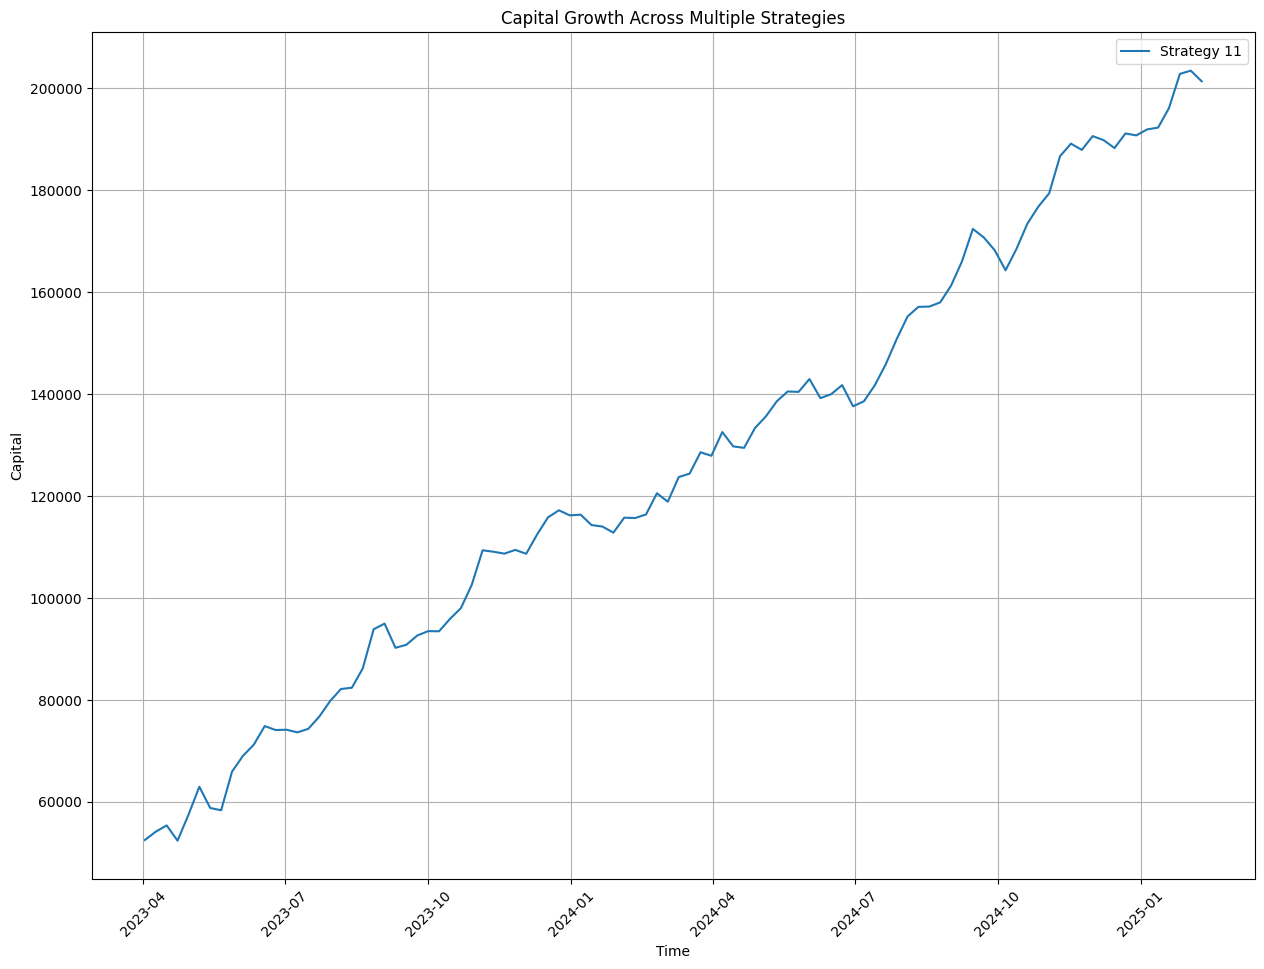

In [3]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[11],
                             plotSize=(15,11))

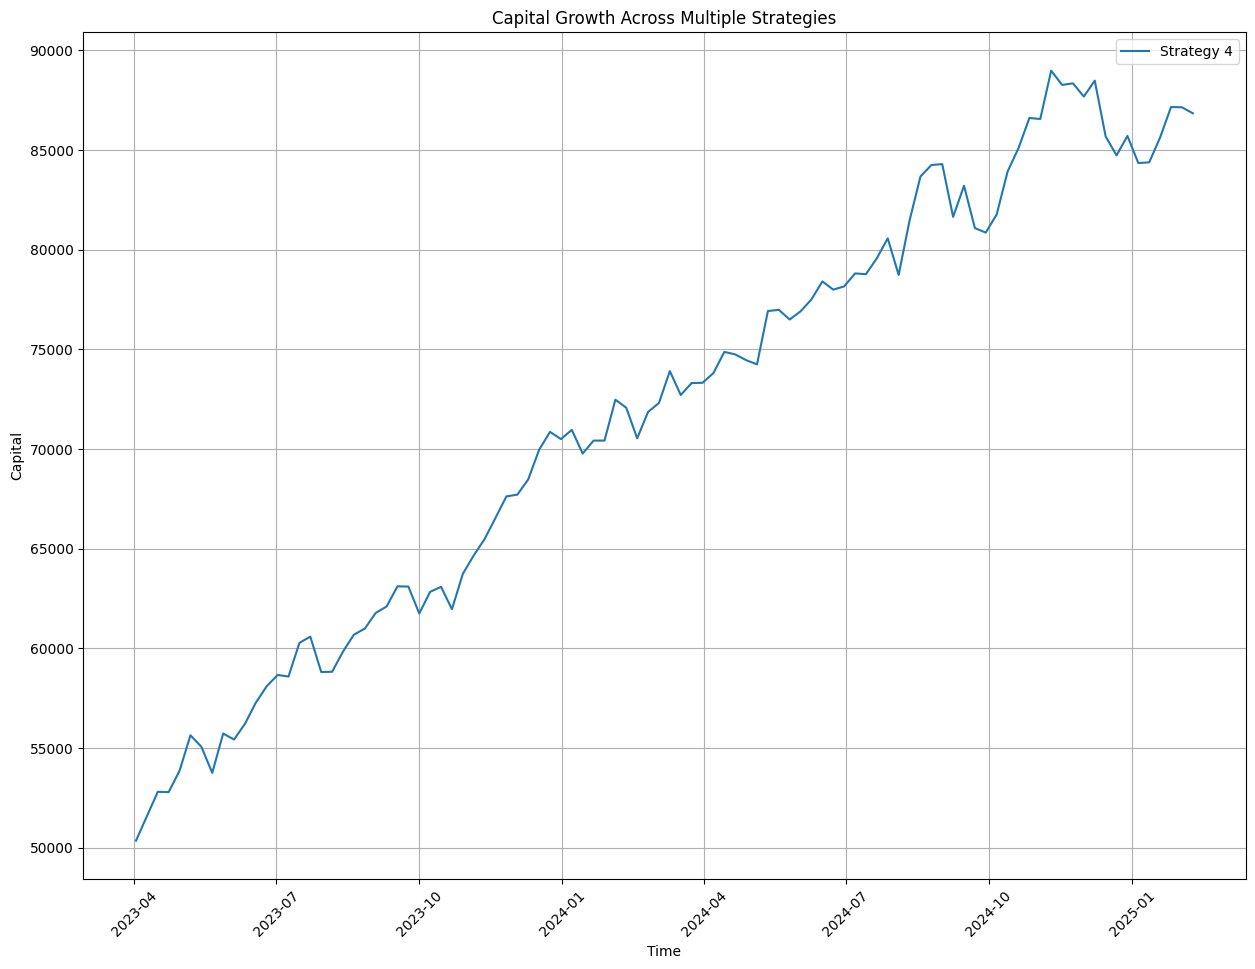

In [15]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[4],
                             plotSize=(15,11))

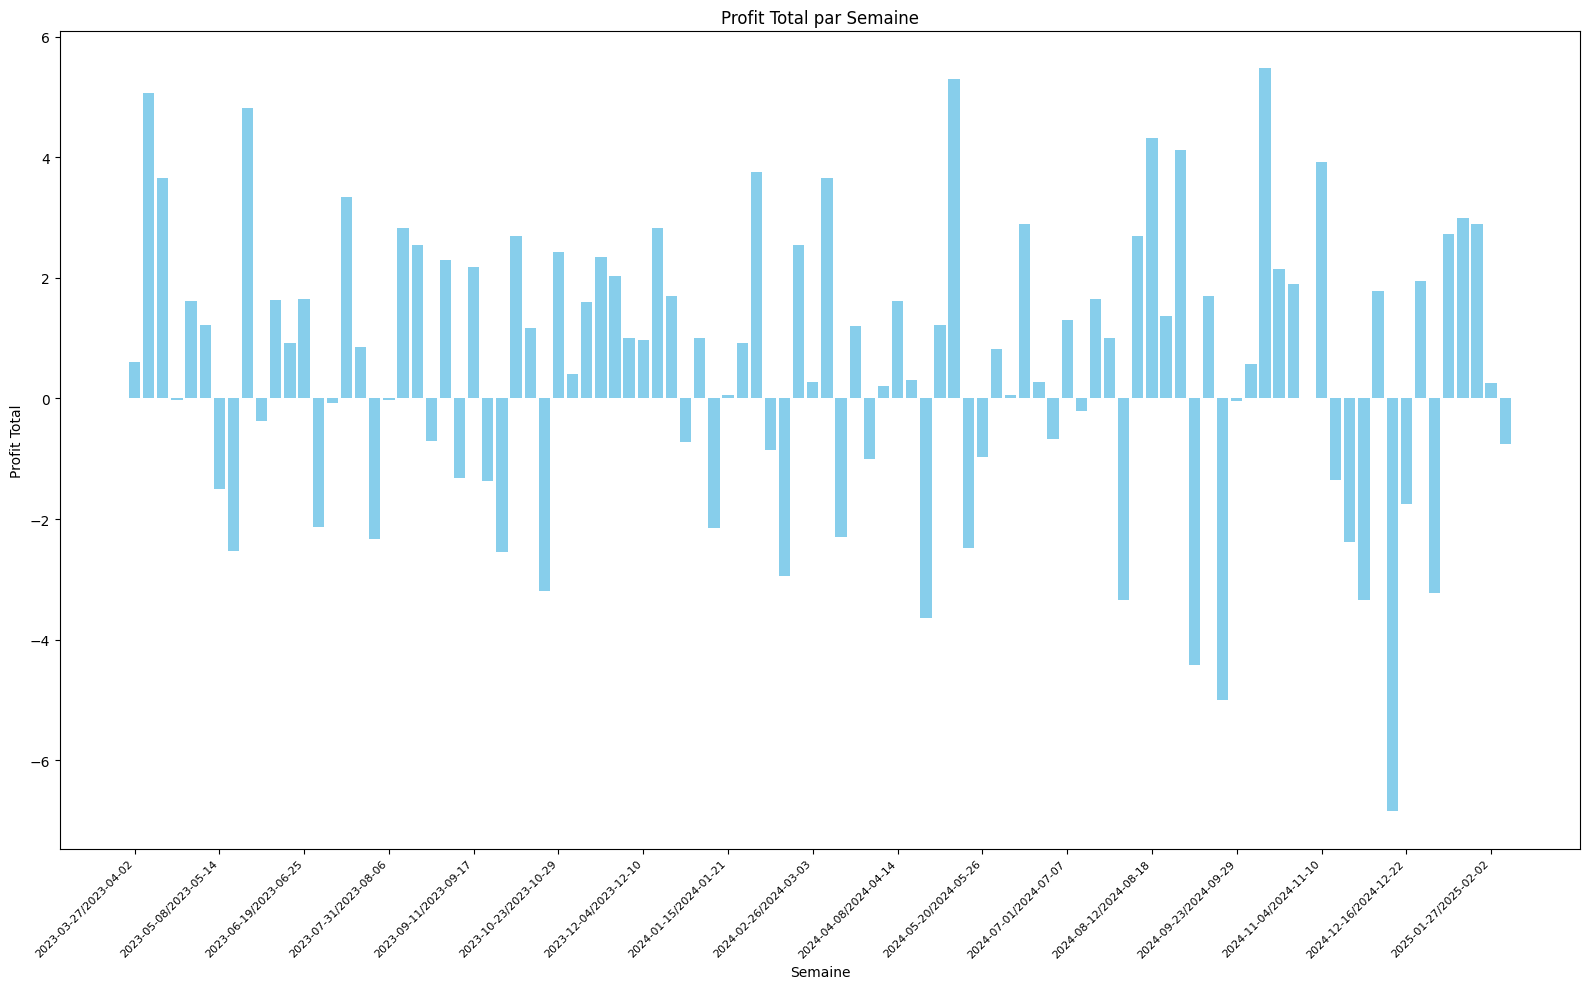

In [7]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 4)

Nouvelles choses à tester : 
- condition de sorties supp. si on a un grand doji/marteau/pendu (***) => fait! : résultats mauvais
- rajouter la possibilité de déplacer le TP si le profit continu. Peut etre avec la tenkan ou avec un autre indicateur? l'ATR? (***)
- stop loss suiveur avec tenkan? => méthode 4; retester avec les méthodes et sans slModifers(**) 
- restester sans niveau de pivot (**)
- rajouter une condition sur la taille de la bougie d'entrée = pas de trade si trop grande (**)
- tester d'augmenter la plage horraire de trading <7h ou >20h (**)
- analyser les heures les moins rentables = forbideenHours (**) 
- raffiner les niveaux de slModifiers/sl/tp (*)
- rajouter les niveaux du plus bas/plus haut journalier aux conditions d'entré (*)

choses à faire pour continuer à backtest : (déjà fait)
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 
- condition sur l'entré en position avec le RSI : entrer seulement si dans la zone de hausse ou de baisse temperé 
- condition sur la taille de la bougie (bougie trop grande = news). On pourra utiliser les taille moyenne de bougie/H
- utilise l'API pour avoir l'historique des news

méthodes à tester maintenant :
- l'ATR défini notre niveau de TP (tester niveau de TP = atrRatio [2,3,4,5])
- la pente de l'ATR défini si on place un TP définitif, ex : si la pente de l'ATR < X et que prix actuel >= 90% TP initial on ne déplace plus le TP